<a href="https://colab.research.google.com/github/Jcc329/Jessica_DATA606/blob/main/Notebooks/5.Topic_Modeling_c_v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 606 Capstone
## Notebook 5
## Phase 2 Part 1: Topic Modeling
Jessica Conroy

<b> Goal: </b> 
This Notebook aims to perform topic modeling to identify key topics and differences in those topics among the pre covid and during covid time frames. 
1. LDA and NMF (non-negative matrix factorization) from game description, reviews, tags
2. Text similarity analysis

In [ ]:
!pip install gensim==3.8.0

     |████████████████████████████████| 24.2 MB 87.0 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
pip install googletrans==3.1.0a0

     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 1.3 MB 37.1 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 65 kB 4.4 MB/s 
     |████████████████████████████████| 53 kB 2.8 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=0b2afd2101ddfaa3deec6cb60c729d9ed65fa06a60dd5277617e5a71686ffb10
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import textwrap

import gensim
print(gensim.__version__)
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LsiModel
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import preprocess_documents
from io import TextIOWrapper

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# print(stopwords.words('english'))


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from googletrans import Translator

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

3.8.0
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Load Data
# GameData = pd.read_csv('./FinalSteamData.csv')
GameData = pd.read_csv('./FinalGameData_postProcessing.csv')
# GameData.head()

# Perform some pre-requisite text processing

In [ ]:
#Remove digits from tags. 

def removedigit(s):
    try:
        s = re.sub("\d+", "", s)
    except: 
        s
    return s
GameData['tags.1'] = GameData['tags.1'].apply(removedigit)
GameData['tags.1']

0        action casual arcade shoot em up d colorful st...
1                                                      NaN
2                                                      NaN
3        bullet hell coop shoot em up replay value grea...
4        action shooter action rpg shoot em up rpg gore...
                               ...                        
14947    adventure indie point click puzzle short casua...
14948                                                  NaN
14949                                     adventure casual
14950                                                  NaN
14951                                                  NaN
Name: tags.1, Length: 14952, dtype: object

In [ ]:
#Lemmatize the text (Lemmatisation in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item)
# Topic modeling functions are informed and guided by another project I worked on https://github.com/Jcc329/Text_Summarization/blob/main/notebooks/Topic_Modeling_YunpengLi.ipynb
# used methods for lemmatizing found here https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None
def nltk_lemmatize(s):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(str(s))) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:       
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence
GameData['tags.1'] = GameData['tags.1'].apply(nltk_lemmatize)
# GameData['tags.1']
GameData['detailed_description.1'] = GameData['detailed_description.1'].apply(nltk_lemmatize)
# GameData['detailed_description.1']
GameData['Top Reviews by Upvotes.1'] = GameData['Top Reviews by Upvotes.1'].apply(nltk_lemmatize)
# GameData['Top Reviews by Upvotes.1']

In [ ]:
#remove additional stopwords
stop_words = set(stopwords.words("english"))
stop_words = stop_words.update(["game",'games', "player", 'play'])

def removestopwords(s):
    #Remove stop words and sent to lowercase
    try:
        s = " ".join([word.lower() for word in str(s).split() if word.lower() not in stop_words])
    except:
        s
    return s

GameData['tags.1'] = GameData['tags.1'].apply(removestopwords)
# GameData['tags.1']
GameData['detailed_description.1'] = GameData['detailed_description.1'].apply(removestopwords)
# GameData['detailed_description.1']
GameData['Top Reviews by Upvotes.1'] = GameData['Top Reviews by Upvotes.1'].apply(removestopwords)
# GameData['Top Reviews by Upvotes.1']

In [ ]:
# Filter out non english text
#https://pypi.org/project/googletrans/
#https://stackoverflow.com/questions/57282711/google-translate-library-is-printing-googletrans-models-translated-at-0x1eaf9bf

def taglanguage(df,col):
    lang_tag = []
    for s in df[col]:
        translator = Translator()
        result = translator.detect(s[0:100])
        lang_tag.append(result.lang)
    # print(lang.detect_language())
    return lang_tag

GameData['tags.Lang'] = taglanguage(GameData, 'tags.1')
# GameData['tags.1']
GameData['detailed_description.Lang'] =  taglanguage(GameData, 'detailed_description.1')
# GameData['detailed_description.1']
GameData['Top Reviews by Upvotes.Lang'] =  taglanguage(GameData, 'Top Reviews by Upvotes.1')
# GameData['detailed_description.Lang']
GameData.to_csv('./FinalGameData_postProcessing.csv')


KeyboardInterrupt: ignored

In [ ]:
from google.colab import files
files.download('FinalGameData_postProcessing.csv')

In [ ]:
GameData[GameData['detailed_description.Lang']!='en']
GameData[GameData['detailed_description.Lang'].astype(str).str.contains('en')]['detailed_description.1'].values
#Nans were interpretted as [ht, zh-CN]	

# Functions for preparing the text data for the LDA/NMF model application and doing coherence testing

In [ ]:
#Split text into corpuses showing array of values
#Create Pre and During Covid data sets to use later:

GameData = GameData.fillna('')
preCOVID = GameData[GameData['Release Year'].isin([2018,2019])]
COVID = GameData[GameData['Release Year'].isin([2021,2022])]
GameData['Top Reviews by Upvotes.1'] = GameData['Top Reviews by Upvotes.1'].str.replace('game', '') #somehow I'm still getting GAME in my all my review results so retrying with this removed

GameData = GameData.fillna('')
# All Data
Descriptions_all = GameData[GameData['detailed_description.Lang'].astype(str).str.contains('en')]['detailed_description.1'].values
Reviews_all = GameData[GameData['Top Reviews by Upvotes.Lang'].astype(str).str.contains('en')]['Top Reviews by Upvotes.1'].values
Tags_all = GameData[GameData['tags.Lang'].astype(str).str.contains('en')]['tags.1'].values

# preCOVID Data
Descriptions_preCOVID = preCOVID[preCOVID['detailed_description.Lang'].astype(str).str.contains('en')]['detailed_description.1'].values
Reviews_preCOVID = preCOVID[preCOVID['Top Reviews by Upvotes.Lang'].astype(str).str.contains('en')]['Top Reviews by Upvotes.1'].values
Tags_preCOVID = preCOVID[preCOVID['tags.Lang'].astype(str).str.contains('en')]['tags.1'].values

# duringCOVID Data
Descriptions_COVID = COVID[COVID['detailed_description.Lang'].astype(str).str.contains('en')]['detailed_description.1'].values
Reviews_COVID = COVID[COVID['Top Reviews by Upvotes.Lang'].astype(str).str.contains('en')]['Top Reviews by Upvotes.1'].values
Tags_COVID = COVID[COVID['tags.Lang'].astype(str).str.contains('en')]['tags.1'].values

In [ ]:
# Function to create dictionary, bag of words, and tokenized text: https://github.com/Jcc329/Text_Summarization/blob/main/notebooks/Topic_Modeling_YunpengLi.ipynb
# https://radimrehurek.com/gensim/parsing/preprocessing.html
def build_dictionary_preprocess_corpus(text_corpus):
  
  # Preprocess documents 
  tokenized_texts = preprocess_documents(text_corpus)
  
  # Create a dictionary
  dictionary = Dictionary(tokenized_texts)
  
  # Create a list of lists of bow for documents
  bow_corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

  return dictionary, bow_corpus, tokenized_texts

In [ ]:
#Function for calculating coherence score: https://github.com/Jcc329/Text_Summarization/blob/main/notebooks/Topic_Modeling_YunpengLi.ipynb
# coherence_type can be 'u_mass' or 'c_v'
# algorithm can be 'LSI' or 'LDA'
def compute_coherence_score(tokenized_texts, bow_corpus, dictionary, num_topics, coherence_type, algorithm):
  if algorithm == 'LSI':
    model = LsiModel(corpus = bow_corpus, num_topics = num_topics, id2word = dictionary)
  else: # algorithm == 'LDA'
    model = LdaModel(corpus = bow_corpus, num_topics = num_topics, id2word = dictionary, passes = 2)

  coherence = CoherenceModel(model=model,
                              corpus=bow_corpus,
                              texts=tokenized_texts,
                              dictionary=dictionary,
                              coherence=coherence_type)
  return coherence.get_coherence()

In [ ]:
def generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm, coherence_type='c_v'):
  
  coherence_scores=[]
  min_score=0
  max_score=0

  best_num_topics=1

  for k in range(min_topics, max_topics):
    score = compute_coherence_score(tokenized_texts, bow_corpus, dictionary, k, coherence_type, algorithm)
    coherence_scores.append(score)

    if coherence_type == 'u_mass':
      if score < min_score :
        min_score = score
        best_num_topics = k
    else: # coherence_type == 'c_v'
      if score > max_score:
        max_score = score
        best_num_topics= k


  return coherence_scores, best_num_topics

In [ ]:
#function for plotting coherence score
import matplotlib.pyplot as plt
import matplotlib.style as style
#%matplotlib inline

def plot_coherence_scores(min_topics, max_topics, coherence_scores, coherence_type, algorithm, legend=''):
  style.use('fivethirtyeight')

  x = [int(i) for i in range(min_topics, max_topics)]

  plt.figure(figsize=(10,8))
  plt.plot(x, coherence_scores)
  plt.xlabel('Number of topics')
  plt.ylabel('Coherence Value')
  plt.title(legend + ' ' + algorithm + ' Coherence Scores by number of Topics (' + coherence_type + ')')

In [ ]:
#Function to print topics
def print_topics(dictionary, bow_corpus, num_topics, algorithm, num_words=10, friendly_print=True):
  
  if algorithm == 'LSI':
    model = LsiModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary)
  else: # algorithm == 'LDA'
    model = LdaModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary, passes=2)

  if friendly_print:
    # Extract terms from results returned by show_topic()
    for topic_number in range(0, num_topics):
      terms = []
      for term, wt in model.show_topic(topic_number, num_words):
        terms.append(term)
    
      print('Topic ' + str(topic_number) + ':', terms)

  else:
    topics = model.print_topics(num_topics, num_words)
    for topic in topics:
      print(topic)

  return model

## Functions for NMF Modeling

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

In [ ]:
def print_NMF_topics(tokenized_texts, max_df=0.95, min_df=1, number_topics=20, number_words_per_topic=10):
  
  text_list=[]

  for token_array in tokenized_texts:
    text_list.append(" ".join(token_array))  # concat tokens for each document to make compatible format for vectorizer.fit_transform()

  vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
  X = vectorizer.fit_transform(text_list)

  idx_to_word = np.array(vectorizer.get_feature_names())

  # apply NMF
  nmf = NMF(n_components=number_topics, solver="mu")
  W = nmf.fit_transform(X)  # document_topics
  H = nmf.components_       # topic_terms

  for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word [topic.argsort()[-number_words_per_topic:]]])))

#Run the models

#All Data

## Descriptions

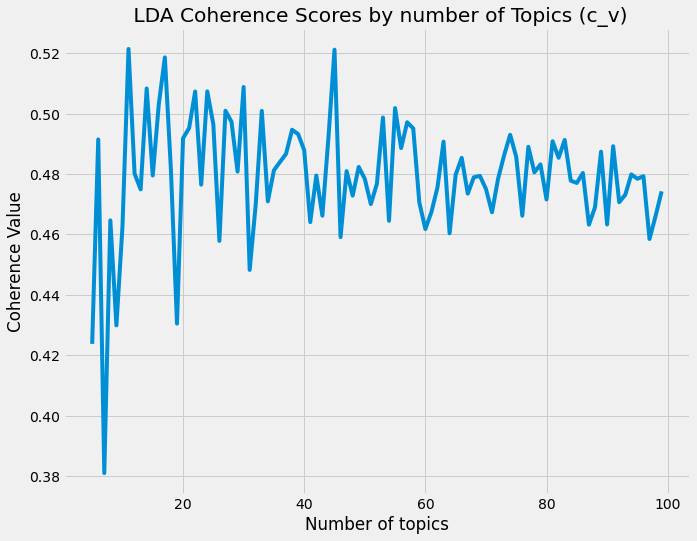

In [ ]:
#We are using u_mass over c_v to calculate coherence because u_mass measures relationships with preceding and subsequent words and tends to perform better when compared with other coherence metrics (https://github.com/dice-group/Palmetto/issues/12)
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Descriptions_all)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [ ]:
print('The best number of Description topics found by c_v coherence score:', best_num_topics_cv_lda)

The best number of Description topics found by c_v coherence score: 11


In [ ]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['object', 'game', 'mansion', 'prison', 'collector', 'room', 'spell', 'kei', 'ghost', 'puzzl', 'click', 'hidden', 'killer', 'warden', 'detect']
Topic 1: ['track', 'music', 'pack', 'race', 'us', 'car', 'theme', 'includ', 'maker', 'featur', 'song', 'game', 'soundtrack', 'new', 'rpg']
Topic 2: ['pack', 'skin', 'dlc', 'includ', 'content', 'item', 'unlock', 'purchas', 'model', 'us', 'new', 'charact', 'set', 'anim', 'outfit']
Topic 3: ['game', 'world', 'level', 'new', 'us', 'differ', 'explor', 'uniqu', 'build', 'time', 'wai', 'surviv', 'challeng', 'power', 'plai']
Topic 4: ['enemi', 'weapon', 'new', 'game', 'ship', 'space', 'shoot', 'plai', 'includ', 'player', 'control', 'level', 'mode', 'gun', 'mission']
Topic 5: ['train', 'new', 'simul', 'line', 'scenario', 'rout', 'farm', 'citi', 'passeng', 'vehicl', 'drive', 'servic', 'includ', 'airport', 'oper']
Topic 6: ['battl', 'new', 'enemi', 'player', 'card', 'game', 'war', 'unit', 'fight', 'map', 'tactic', 'power', 'combat', 'hero', 'forc

In [ ]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: fight,time,enemi,weapon,differ,level,plai,mode,player,game
Topic 2: line,break,shoot,baseor,gamein,aboutquottig,tank,tanksthrough,topdown,enemi
Topic 3: amp,plai,new,includ,authent,electr,song,tone,bass,guitar
Topic 4: updat,discount,late,twice,note,instal,care,costum,purchas,content
Topic 5: logic,relax,piec,jigsaw,challeng,difficulti,game,solv,level,puzzl
Topic 6: discov,charact,dark,secret,explor,new,mysteri,adventur,stori,world
Topic 7: gamefeatureth,dlc,combat,game,larg,number,aboutthi,player,fighter,shoot
Topic 8: defeat,battl,base,guard,dlc,contain,reopen,indring,feature,tank
Topic 9: file,weapon,rpg,color,includ,new,charact,maker,skin,pack
Topic 10: workshop,drive,line,steam,class,simul,rout,scenario,locomot,train
Topic 11: dragon,level,charact,power,battl,spell,magic,dungeon,hero,monster
Topic 12: activ,ultim,subscript,adventur,licens,ruleset,map,pathfind,ground,fantasi
Topic 13: event,player,oppon,collect,plai,solitair,add,new,deck,card
Topic 14: maker,format,origin,

## Reviews

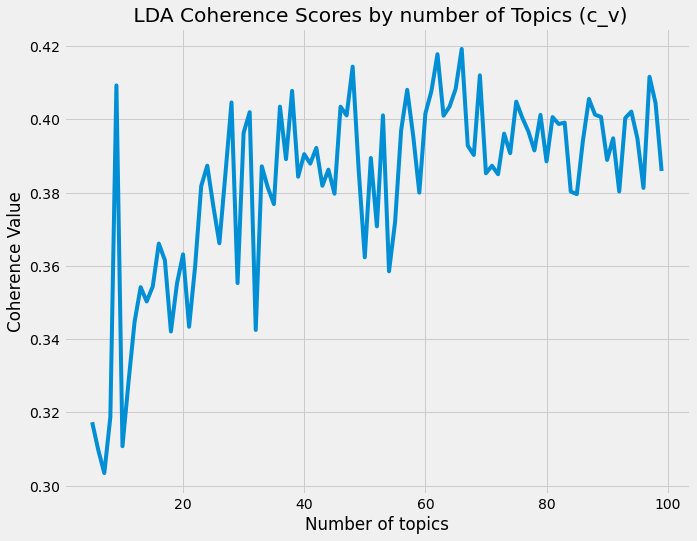

In [ ]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Reviews_all)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [ ]:
print('The best number of Review topics found by C_V coherence score:', best_num_topics_cv_lda)

The best number of Review topics found by C_V coherence score: 66


In [ ]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['frost', 'preorder', 'okit', 'nr', 'kahn', 'longhaul', 'shao', 'daddi', 'charact', 'paywal', 'like', 'krush', 'plai', 'good', 'stori']
Topic 1: ['zork', 'parser', 'infocom', 'fluidli', 'underwat', 'spelunki', 'thee', 'pew', 'anchorhead', 'like', 'cat', 'plai', 'marketplac', 'control', 'fun']
Topic 2: ['rythm', 'refuel', 'diner', 'dope', 'exorc', 'itin', 'dougla', 'apolog', 'quarantin', 'bibl', 'thinga', 'plai', 'wineri', 'sip', 'like']
Topic 3: ['chess', 'vocabulari', 'tileset', 'lego', 'board', 'overcook', 'pronoun', 'piec', 'exercis', 'mate', 'hood', 'mover', 'word', 'plai', 'que']
Topic 4: ['plai', 'like', 'time', 'good', 'look', 'puzzl', 'thing', 'wai', 'room', 'us', 'run', 'end', 'pretti', 'lot', 'think']
Topic 5: ['us', 'work', 'softwar', 'program', 'bui', 'tool', 'like', 'version', 'plane', 'good', 'fly', 'need', 'creat', 'want', 'great']
Topic 6: ['dog', 'pet', 'savior', 'superhot', 'klei', 'broforc', 'prowess', 'wobbl', 'puppi', 'obsess', 'level', 'oblivion', 'tail',

In [ ]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: wai,want,think,try,feel,look,thing,like,time,plai
Topic 2: relax,pictur,easi,achiev,nice,object,stori,piec,solv,puzzl
Topic 3: pai,worth,add,content,free,base,pack,new,bui,dlc
Topic 4: control,music,design,simpl,complet,plai,achiev,platform,challeng,level
Topic 5: download,short,recommend,usual,music,easi,stori,graphic,pretti,good
Topic 6: shoot,damag,fight,combat,attack,level,platform,boss,weapon,enemi
Topic 7: scene,love,visual,art,choic,short,end,novel,charact,stori
Topic 8: build,enemi,tactic,strategi,war,map,campaign,battl,mission,unit
Topic 9: look,awesom,amaz,challeng,soundtrack,mode,fun,love,platform,great
Topic 10: easi,shoot,worth,simpl,hard,littl,short,pretti,lot,fun
Topic 11: engin,cab,locomot,sound,loco,drive,scenario,train,car,rout
Topic 12: pretti,cool,kind,nice,wish,art,look,stuff,feel,like
Topic 13: access,earli,abandon,achiev,support,dev,updat,monei,develop,bui
Topic 14: note,guitar,rhythm,soundtrack,track,bass,plai,pack,music,song
Topic 15: color,nice,charac

## Tags

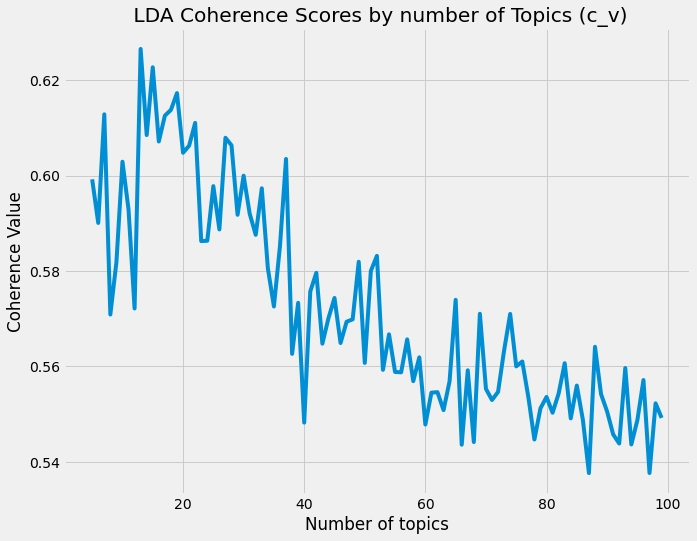

In [ ]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Tags_all)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [ ]:
print('The best number of Review topics found by c_v coherence score:', best_num_topics_cv_lda)

The best number of Review topics found by c_v coherence score: 13


In [ ]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['simul', 'world', 'open', 'sandbox', 'access', 'earli', 'strategi', 'singleplay', 'sim', 'indi', 'manag', 'realist', 'sport', 'race', 'build']
Topic 1: ['adventur', 'rich', 'stori', 'singleplay', 'indi', 'casual', 'click', 'point', 'novel', 'visual', 'mysteri', 'protagonist', 'atmospher', 'anim', 'femal']
Topic 2: ['strategi', 'manag', 'sexual', 'content', 'nuditi', 'singleplay', 'classic', 'time', 'simul', 'indi', 'tactic', 'defens', 'tower', 'anim', 'resourc']
Topic 3: ['rpg', 'turnbas', 'strategi', 'fantasi', 'tactic', 'combat', 'action', 'singleplay', 'indi', 'dungeon', 'adventur', 'jrpg', 'crawler', 'hack', 'slash']
Topic 4: ['plai', 'free', 'multiplay', 'massiv', 'indi', 'action', 'strategi', 'rpg', 'earli', 'access', 'simul', 'adventur', 'pvp', 'royal', 'battl']
Topic 5: ['indi', 'action', 'adventur', 'horror', 'casual', 'violent', 'simul', 'gore', 'psycholog', 'access', 'earli', 'surviv', 'rpg', 'dark', 'firstperson']
Topic 6: ['coop', 'multiplay', 'local', 'action', 

In [ ]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: difficult,fight,soundtrack,actionadventur,hack,slash,roguelik,adventur,indi,action
Topic 2: singleplay,world,sandbox,realist,flight,sim,walk,manag,casual,simul
Topic 3: femal,protagonist,fantasi,explor,great,soundtrack,atmospher,singleplay,rich,stori
Topic 4: space,histor,war,multiplay,grand,defens,tower,rt,manag,strategi
Topic 5: surviv,player,pvp,open,onlin,world,massiv,local,coop,multiplay
Topic 6: interact,fiction,novel,visual,rpg,rpgmaker,choos,textbas,indi,adventur
Topic 7: card,casual,sport,clicker,indi,rpg,multiplay,massiv,free,plai
Topic 8: massiv,open,hack,slash,roguelik,jrpg,fantasi,rpgmaker,indi,rpg
Topic 9: fp,gore,zombi,atmospher,dark,indi,firstperson,psycholog,surviv,horror
Topic 10: difficult,precis,adventur,retro,scroller,puzzleplatform,pixel,graphic,indi,platform
Topic 11: design,manag,sim,craft,build,sandbox,util,casual,earli,access
Topic 12: detect,famili,friendli,mysteri,adventur,casual,point,click,hidden,object
Topic 13: soccer,offroad,esport,footbal,sim,

#Pre-Covid
## Descriptions

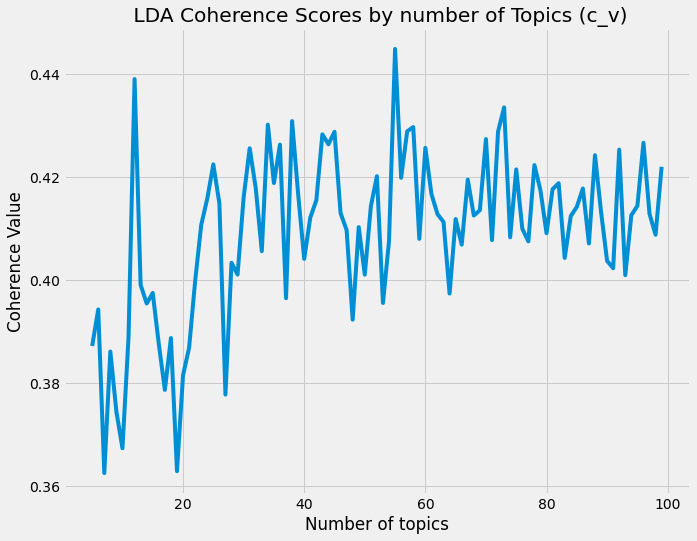

In [ ]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Descriptions_preCOVID)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [ ]:
print('The best number of Review topics found by c_v coherence score:', best_num_topics_cv_lda)

The best number of Review topics found by c_v coherence score: 55


In [ ]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['nanobot', 'plai', 'tone', 'includ', 'song', 'new', 'electr', 'dinosaur', 'authent', 'guitar', 'bass', 'estim', 'rock', 'queen', 'girlfriend']
Topic 1: ['aerial', 'demon', 'adjac', 'board', 'ransack', 'squar', 'us', 'game', 'gestur', 'piec', 'press', 'fruit', 'wallpap', 'player', 'button']
Topic 2: ['orion', 'fish', 'spider', 'attack', 'synth', 'brink', 'black', 'loop', 'breez', 'crank', 'minnow', 'equip', 'shad', 'releasehttpsstoresteampoweredcomappabout', 'escap']
Topic 3: ['recur', 'drag', 'side', 'postprocess', 'basin', 'lucid', 'brief', 'new', 'red', 'weight', 'useless', 'hold', 'origin', 'oper', 'speed']
Topic 4: ['dead', 'fighter', 'aliv', 'core', 'breaker', 'offer', 'content', 'free', 'game', 'period', 'time', 'download', 'limit', 'note', 'us']
Topic 5: ['game', 'player', 'new', 'differ', 'uniqu', 'enemi', 'world', 'weapon', 'plai', 'time', 'wai', 'experi', 'build', 'creat', 'charact']
Topic 6: ['insight', 'effect', 'shatter', 'music', 'remix', 'soundtrackquot', 'furi

In [ ]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: fight,skill,time,control,enemi,differ,mode,player,plai,game
Topic 2: price,note,discount,late,costum,instal,twice,care,purchas,content
Topic 3: youquot,new,plai,includ,song,electr,authent,bass,guitar,tone
Topic 4: relax,complet,level,difficulti,contain,piec,game,jigsaw,solv,puzzl
Topic 5: island,life,secret,new,charact,explor,mysteri,stori,world,adventur
Topic 6: action,men,festa,titl,young,rhythm,rout,quotla,corda,doro
Topic 7: imag,origin,art,file,includ,wallpap,artbook,game,folder,dlc
Topic 8: allow,game,effect,warrior,offic,appli,correspond,quotdynasti,trialquot,ticket
Topic 9: ultim,ruleset,licens,subscript,higherrequir,monster,pathfind,map,ground,fantasi
Topic 10: costumequot,hideawai,galleri,menu,outfit,regular,charact,chang,costum,select
Topic 11: new,build,win,plai,oppon,memori,game,player,deck,card
Topic 12: campaign,war,tower,mission,unit,defens,battl,new,enemi,weapon
Topic 13: scenario,locomot,liveri,vehicl,passeng,simul,drive,race,train,car
Topic 14: rpg,bgm,town,

## Reviews

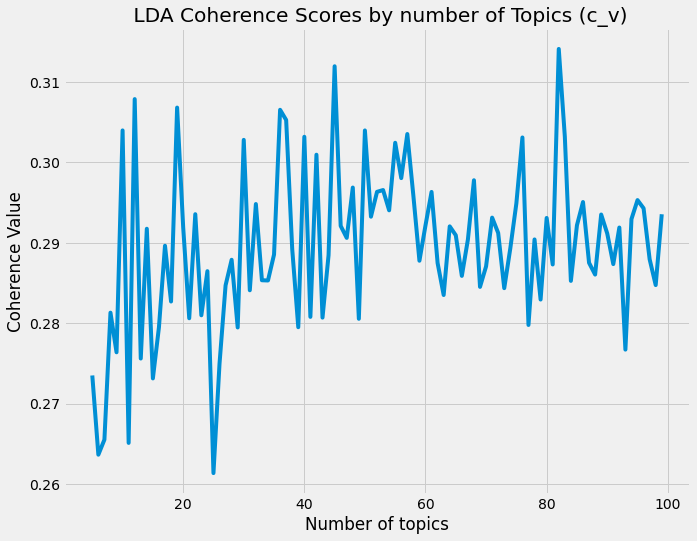

In [ ]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Reviews_preCOVID)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [ ]:
print('The best number of Review topics found by u-mass coherence score:', best_num_topics_cv_lda)

The best number of Review topics found by u-mass coherence score: 82


In [ ]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['und', 'game', 'spear', 'africa', 'us', 'trailer', 'gestur', 'lemon', 'plai', 'look', 'like', 'weapon', 'nice', 'best', 'lot']
Topic 1: ['game', 'plai', 'fun', 'like', 'bui', 'good', 'onlin', 'look', 'friend', 'time', 'recommend', 'card', 'easi', 'board', 'simpl']
Topic 2: ['game', 'incomprehens', 'like', 'pretti', 'boi', 'dude', 'man', 'awesom', 'good', 'time', 'plai', 'puzzl', 'charact', 'stori', 'railwai']
Topic 3: ['sudoku', 'snake', 'game', 'plai', 'merci', 'understand', 'eyecatch', 'like', 'that', 'unintuit', 'support', 'control', 'recommend', 'good', 'pencil']
Topic 4: ['game', 'mask', 'cosmet', 'lmao', 'kahn', 'shao', 'nr', 'dlc', 'us', 'gear', 'time', 'plai', 'like', 'fun', 'pretti']
Topic 5: ['game', 'klei', 'hipster', 'good', 'set', 'like', 'time', 'plai', 'charact', 'great', 'emporium', 'new', 'phenix', 'dlcit', 'stori']
Topic 6: ['card', 'game', 'doodl', 'time', 'reenter', 'wsma', 'like', 'plai', 'immun', 'ccg', 'deck', 'long', 'maze', 'good', 'race']
Topic 7: ['

In [ ]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: think,recommend,wai,work,need,develop,like,time,plai,game
Topic 2: mechan,challeng,solut,complet,relax,jigsaw,pictur,solv,piec,puzzl
Topic 3: write,time,scene,novel,feel,choic,like,end,charact,stori
Topic 4: bass,soooooooooooooooooooooo,stuff,graphic,match,art,stori,game,usual,good
Topic 5: difficulti,hard,editor,enemi,design,finish,good,challeng,platform,level
Topic 6: add,purchas,librari,best,worth,costum,pack,new,bui,dlc
Topic 7: lot,sale,kid,challeng,easi,littl,friend,hard,short,fun
Topic 8: fast,bui,profil,min,unlock,steam,easi,hunter,game,achiev
Topic 9: model,engin,fly,locomot,aircraft,plane,train,sound,work,car
Topic 10: soundtrack,fast,version,excit,like,expert,plai,pack,music,song
Topic 11: bot,ball,multiplay,footbal,onlin,mode,tabl,friend,player,plai
Topic 12: damag,boss,attack,kill,wave,shooter,shoot,gun,weapon,enemi
Topic 13: bui,feel,ship,art,great,look,amaz,support,skin,like
Topic 14: definit,look,bit,graphic,game,soundtrack,great,relax,music,nice
Topic 15: sign

## Tags

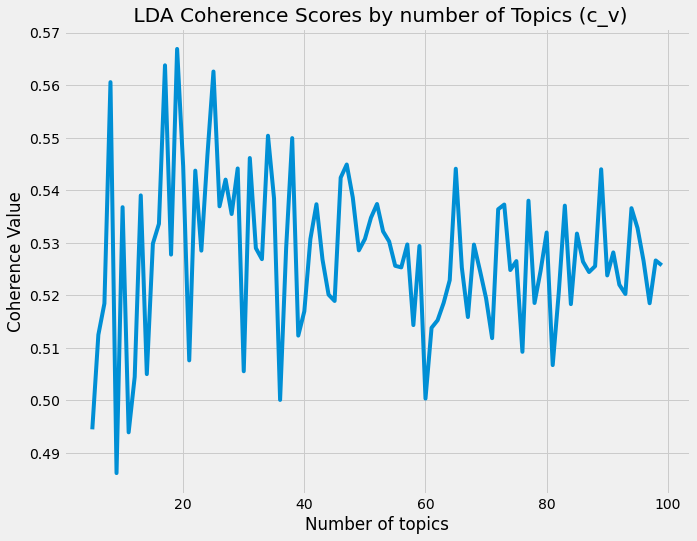

In [ ]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Tags_preCOVID)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [ ]:
print('The best number of Review topics found by c_v coherence score:', best_num_topics_cv_lda)

The best number of Review topics found by c_v coherence score: 19


In [ ]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['replai', 'valu', 'indi', 'singleplay', 'atmospher', 'famili', 'friendli', 'short', 'casual', 'dark', 'relax', 'difficult', 'multipl', 'end', 'addict']
Topic 1: ['indi', 'action', 'adventur', 'earli', 'access', 'violent', 'casual', 'free', 'plai', 'rpg', 'strategi', 'gore', 'multiplay', 'simul', 'massiv']
Topic 2: ['local', 'multiplay', 'casual', 'friendli', 'famili', 'indi', 'singleplay', 'classic', 'cute', 'color', 'fastpac', 'control', 'arcad', 'retro', 'physic']
Topic 3: ['simul', 'indi', 'casual', 'strategi', 'sport', 'adventur', 'action', 'race', 'manag', 'rpg', 'hidden', 'object', 'singleplay', 'sim', 'friendli']
Topic 4: ['strategi', 'manag', 'turnbas', 'tactic', 'rpg', 'singleplay', 'indi', 'simul', 'combat', 'resourc', 'world', 'fantasi', 'sandbox', 'train', 'space']
Topic 5: ['soundtrack', 'great', 'difficult', 'singleplay', 'action', 'shooter', 'scifi', 'indi', 'robot', 'free', 'plai', 'platform', 'firstperson', 'retro', 'protagonist']
Topic 6: ['local', 'multipla

In [ ]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: tank,nuditi,music,educ,simul,arcad,action,adventur,casual,indi
Topic 2: actionadventur,beat,roguelit,shoot,slash,hack,roguelik,difficult,adventur,action
Topic 3: surviv,singleplay,train,realist,strategi,walk,sim,manag,action,simul
Topic 4: puzzleplatform,fmv,explor,point,click,rpg,rpgmaker,choos,textbas,adventur
Topic 5: singleplay,horror,puzzleplatform,difficult,card,clicker,multiplay,massiv,free,plai
Topic 6: histor,board,space,manag,rt,tower,defens,action,indi,strategi
Topic 7: atmospher,funni,retro,graphic,pixel,difficult,great,soundtrack,singleplay,platform
Topic 8: indi,craft,sandbox,world,open,roguelik,fp,rpg,earli,access
Topic 9: slash,roguelit,partybas,fantasi,roguelik,jrpg,textbas,anim,rpgmaker,rpg
Topic 10: dinosaur,dark,surviv,zombi,fp,nuditi,horror,indi,gore,violent
Topic 11: golf,arcad,drive,motorbik,basketbal,footbal,automobil,indi,race,sport
Topic 12: violent,time,board,multiplay,sport,card,game,action,adventur,casual
Topic 13: nsfw,meme,protagonist,femal,henta

# Covid Data
## Description

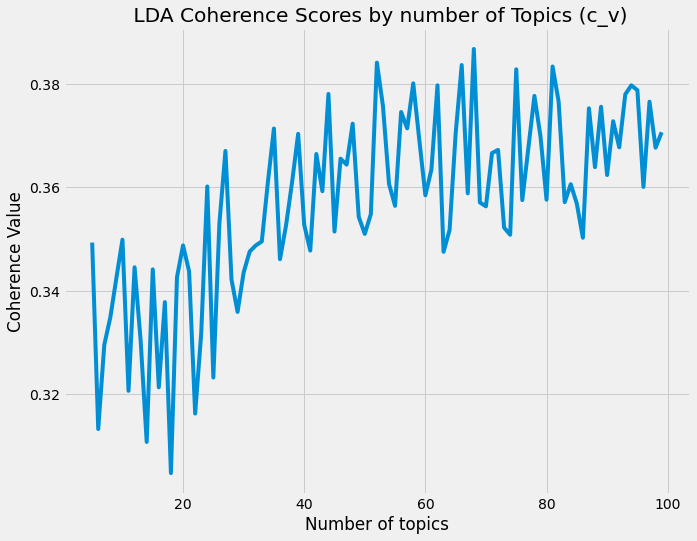

In [ ]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Descriptions_COVID)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [ ]:
print('The best number of Review topics found by u-mass coherence score:', best_num_topics_cv_lda)

The best number of Review topics found by u-mass coherence score: 68


In [ ]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['game', 'world', 'team', 'charact', 'new', 'militari', 'object', 'featur', 'wai', 'time', 'forc', 'manag', 'plai', 'battl', 'locat']
Topic 1: ['us', 'pack', 'maker', 'rpg', 'content', 'seri', 'commerci', 'edit', 'type', 'tile', 'treasur', 'quotrpg', 'includ', 'adultr', 'gore']
Topic 2: ['game', 'spider', 'weapon', 'new', 'us', 'life', 'simul', 'space', 'player', 'paint', 'tool', 'salt', 'build', 'time', 'ship']
Topic 3: ['us', 'music', 'metal', 'theme', 'battl', 'town', 'game', 'track', 'pack', 'project', 'drama', 'poker', 'neon', 'includ', 'sound']
Topic 4: ['game', 'dlc', 'train', 'includ', 'file', 'battl', 'base', 'classic', 'contain', 'rout', 'tank', 'map', 'simul', 'steam', 'enemi']
Topic 5: ['type', 'item', 'game', 'vtuber', 'ghost', 'stori', 'player', 'charact', 'chang', 'patriot', 'weapon', 'world', 'vaccin', 'battl', 'us']
Topic 6: ['game', 'girl', 'item', 'castl', 'block', 'level', 'thief', 'mode', 'monster', 'charact', 'abil', 'new', 'player', 'puzzl', 'collect']
T

In [ ]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: shoot,baseor,break,line,gamein,aboutquottig,tanksthrough,topdown,tank,enemi
Topic 2: experi,friend,stori,mode,differ,world,time,player,plai,game
Topic 3: win,game,combat,aboutthi,larg,number,fighter,player,enemi,shoot
Topic 4: dlc,defeat,classic,base,contain,guard,reopen,indring,feature,tank
Topic 5: necessari,updat,set,purchas,sell,separ,product,version,content,item
Topic 6: pictur,game,art,jigsaw,beauti,relax,difficulti,level,solv,puzzl
Topic 7: scroll,king,horizont,fat,space,map,pig,starri,moon,island
Topic 8: old,air,mission,fighter,kid,fleet,warfar,naval,aboutth,featureth
Topic 9: collect,reach,ball,game,control,obstacl,challeng,jump,platform,level
Topic 10: item,enemi,adventur,fight,power,weapon,monster,explor,world,new
Topic 11: record,theme,mode,skrillex,race,download,rat,new,track,music
Topic 12: adapt,purchas,licens,subscript,time,pathfind,uniti,ruleset,ground,fantasi
Topic 13: tile,content,seri,gore,adultr,commerci,project,rpg,maker,pack
Topic 14: box,addon,statu,be

## Reviews

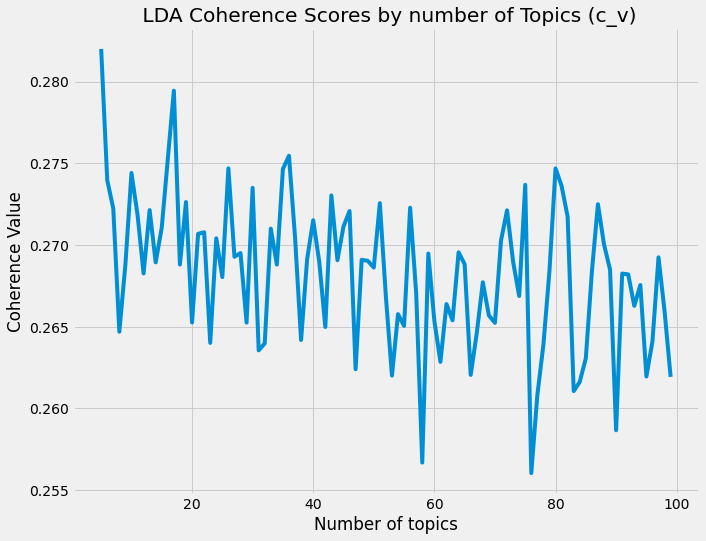

In [ ]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Reviews_COVID)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [ ]:
print('The best number of Review topics found by c_v coherence score:', best_num_topics_cv_lda)

The best number of Review topics found by c_v coherence score: 5


In [ ]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['game', 'plai', 'good', 'like', 'time', 'bui', 'fun', 'wai', 'look', 'want', 'us', 'feel', 'need', 'lot', 'great']
Topic 1: ['game', 'like', 'plai', 'time', 'good', 'feel', 'stori', 'us', 'charact', 'recommend', 'look', 'try', 'star', 'reach', 'wai']
Topic 2: ['game', 'like', 'plai', 'good', 'level', 'time', 'feel', 'stori', 'puzzl', 'fun', 'think', 'great', 'us', 'new', 'love']
Topic 3: ['game', 'like', 'plai', 'good', 'time', 'fun', 'level', 'great', 'recommend', 'look', 'want', 'puzzl', 'need', 'lot', 'nice']
Topic 4: ['game', 'like', 'plai', 'good', 'time', 'fun', 'stori', 'charact', 'lot', 'feel', 'need', 'us', 'thing', 'wai', 'look']


In [ ]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: look,hour,enemi,lot,plai,thing,feel,like,time,game
Topic 2: enadont,known,gameswhi,badnergi,hunterloli,ena,hair,reason,monster,hunter
Topic 3: music,achiev,solv,jigsaw,simpl,relax,piec,easi,game,puzzl
Topic 4: potenti,definit,funni,great,best,recommend,dev,develop,love,game
Topic 5: amtrak,want,free,pretti,gameplai,look,timekil,game,bore,good
Topic 6: littl,differ,worth,simpl,pretti,challeng,minut,crash,lot,fun
Topic 7: ye,addit,song,outfit,ship,new,gun,great,bui,dlc
Topic 8: short,scene,choic,love,art,visual,end,novel,charact,stori
Topic 9: art,price,convert,monei,worth,bui,pixel,color,pictur,pack
Topic 10: challeng,lol,platform,kind,pretti,funni,recommend,wholesom,feel,like
Topic 11: jump,word,iv,peopl,onlin,mode,enjoi,player,friend,plai
Topic 12: wait,gener,think,anim,mode,satisfi,need,calm,work,great
Topic 13: tight,simpl,short,love,challeng,design,music,gameplai,platform,level
Topic 14: big,music,amaz,look,updat,younic,relax,ye,control,nice
Topic 15: weapon,mario,visibl,c

## Tags

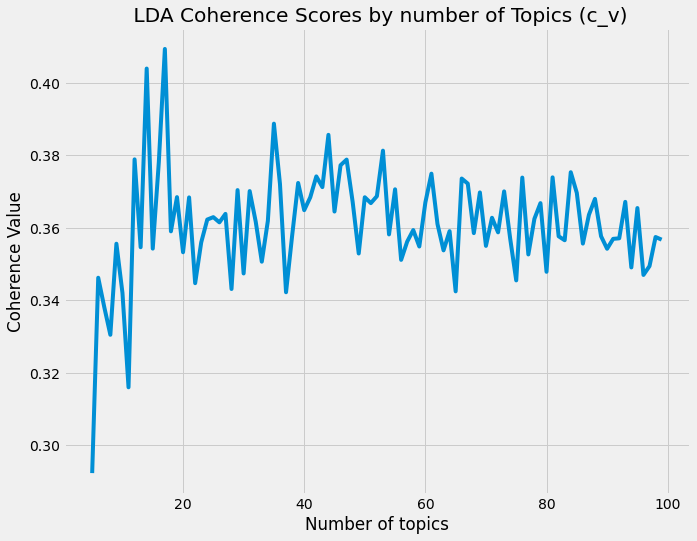

In [ ]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Tags_COVID)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [ ]:
print('The best number of Review topics found by c_v coherence score:', best_num_topics_cv_lda)

The best number of Review topics found by c_v coherence score: 17


In [ ]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['adventur', 'rich', 'stori', 'singleplay', 'casual', 'rpg', 'platform', 'indi', 'anim', 'action', 'novel', 'simul', 'visual', 'end', 'multipl']
Topic 1: ['rpg', 'singleplay', 'roguelik', 'game', 'dungeon', 'strategi', 'fantasi', 'indi', 'crawler', 'casual', 'turnbas', 'gener', 'procedur', 'action', 'topdown']
Topic 2: ['platform', 'singleplay', 'indi', 'action', 'casual', 'adventur', 'pixel', 'linear', 'graphic', 'atmospher', 'minimalist', 'attack', 'strategi', 'color', 'precis']
Topic 3: ['horror', 'singleplay', 'adventur', 'simul', 'indi', 'firstperson', 'explor', 'surviv', 'psycholog', 'dark', 'action', 'atmospher', 'mysteri', 'realist', 'puzzl']
Topic 4: ['strategi', 'singleplay', 'friendli', 'famili', 'casual', 'simul', 'color', 'action', 'shooter', 'tactic', 'atmospher', 'manag', 'fantasi', 'indi', 'adventur']
Topic 5: ['singleplay', 'adventur', 'casual', 'color', 'point', 'click', 'puzzl', 'indi', 'object', 'mysteri', 'hidden', 'atmospher', 'horror', 'cute', 'rich']
To

In [ ]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: physic,casual,singleplay,indi,scroller,linear,adventur,puzzleplatform,precis,platform
Topic 2: jrpg,magic,wargam,war,fantasi,combat,rpg,tactic,strategi,turnbas
Topic 3: fiction,adventur,matter,choic,end,multipl,novel,visual,stori,rich
Topic 4: fp,gore,actionadventur,stealth,adventur,dark,firstperson,surviv,psycholog,horror
Topic 5: atmospher,famili,friendli,minimalist,relax,logic,indi,singleplay,casual,puzzl
Topic 6: combat,thirdperson,scifi,arena,hell,bullet,shoot,action,topdown,shooter
Topic 7: arcad,parti,massiv,teambas,player,pvp,onlin,local,multiplay,coop
Topic 8: firstperson,farm,manag,build,realist,sandbox,life,immers,simul,sim
Topic 9: dark,magic,mediev,actionadventur,adventur,hack,slash,fantasi,action,rpg
Topic 10: casual,nsfw,matur,hentai,protagonist,femal,anim,nuditi,sexual,content
Topic 11: arcad,scroller,singleplay,topdown,indi,old,school,retro,pixel,graphic
Topic 12: difficult,crawler,action,dungeon,death,perma,roguelit,procedur,gener,roguelik
Topic 13: handdrawn

In [ ]:
## LDAvis 

In [ ]:
!pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6 MB 14.2 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=dc0f3c8dbc581b243822c196800b0cb6f2894c60c428347f125b55c95c33b0a6
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis


In [ ]:
import pyLDAvis.gensim

# Visualize the topics
pyLDAvis.enable_notebook()

In [ ]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

# See Notebook 5.2 for text similarity analysis